# ----------
# RIS-aided  Sensing - Submodular Optimization
# Copyright (C) 2023  Tara(Zahra) Esmaeilbeig
# E-mail: taraesmq at gmail dot com
# ----------



In [80]:
## Written  by Z.E.
## July 5, 2023
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
import  itertools
import copy
from google.colab import drive
from itertools import chain, combinations
import  random

drive.mount('/content/gdrive')
class struct():
    '''
    an empty class to use structure type variable
    '''
    pass

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Initialization

In [81]:
radar_position=[0,0]  #x-y location
target_position=[-50,50]
params=struct()
params.radar=radar_position
params.target_position=target_position
np.random.seed(seed=2021)

# Maximum number of  IRSs
M=4     # number of IRSs available
K=4    # number of elements in each IRS
params.M=M
params.K=K
#Phi=np.zeros((M,K,K))
#Phi=Phase_shift_initialization(Phi,M,K)
SNR_db=20   #dB
SNR=10**(SNR_db/20)
params.SNR=SNR
params.Phi=np.diag(np.exp(1j*2*pi*np.random.rand(K)))


# Grid points
Ranges= np.arange(5,100,20)
Azimuth_angles=np.arange(0,2*pi+pi/2,pi/6)
params.A= list(itertools.product(Ranges, Azimuth_angles))





In [82]:
def powerset(iterable):

    s = list(iterable)
    list(itertools.combinations((1, 2, 3), 2))
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def powerset_M(iterable,M):

    s = list(iterable)
    return list(itertools.combinations(s, M))

def  Phase_shift_initialization(Phi,M,K):
  for m in range(0,M):
    v_m=2*pi*random.rand(K)
    Phi[m]=np.diag(np.exp(1j*v_m))


  return Phi


def steering(K,theta):
 steer_vec=np.exp(1j*np.pi*np.sin(theta)*np.arange(0,K,1) )  # d is set to  lambda/2
 steer_vec=np.transpose(steer_vec[np.newaxis])

 return  steer_vec

def  NLoS_Channel(H_ri,Phi,H_ti):

  H_m=np.transpose(H_ri).dot(Phi).dot(H_ti).dot(np.transpose(H_ti)).dot(Phi).dot(H_ri)
  #print(H_m,'\n')

  return H_m


def compute_objective(S,params):
  H=np.empty((params.K,params.K))


  for s in S:

    (x_i,y_i)=pol2cart(s[0],s[1])
    theta_ri=s[1]
    a_t=steering(K,theta_ri)
    b_m=steering(K,theta_ri)
    H_ri=matmul(b_m,transpose(a_t))
    x_t=params.target_position[0]
    y_t=params.target_position[1]
    (r_ti,theta_ti)=cart2pol(x_t-x_i,y_t-y_i)
    H_ti=steering(K,theta_ti)
    H_s=NLoS_Channel(H_ri,np.squeeze(params.Phi),H_ti)

    H=np.append(H, H_s, axis=0)
    t=H.shape[0]
    temp=np.add((params.SNR**2)*H.dot(H.conj().T),np.identity(t))
    obj=np.log(np.linalg.det(temp))
  return obj

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def set_marker_size(x, factor):
    return [x_i**factor for x_i in x]

##Greedy Algorithm##


In [83]:
num_selected_IRS=0
set_S=[]
f_S=[]

updated_A= copy.deepcopy(params.A)
#print(updated_A)
while num_selected_IRS < params.M:
   f_S_temp=[]
   atoms=[]

   for  e in updated_A:
      set_S_temp=copy.deepcopy(set_S)
      set_S_temp.append(e)
      params.candidate_IRS_position=pol2cart(e[0],e[1])
      f_S_temp.append(compute_objective(set_S_temp,params))
      atoms.append(e)

   sel=np.argmax(np.real(f_S_temp))
   set_S.append(atoms[sel])
   num_selected_IRS+=1
   f_S.append(f_S_temp[sel])
   updated_A.remove(atoms[sel])

print('final set of locations',set_S)
print('obj value',f_S)

final set of locations [(5, 7.330382858376184), (65, 2.617993877991494), (5, 3.665191429188092), (85, 0.0)]
obj value [(23.941335006595555-6.434572572197971e-12j), (35.13882640714592-8.768094179979364e-12j), (41.87064077011648-1.6872090468932968e-11j), (45.553053606635984-1.6256610832762407e-12j)]


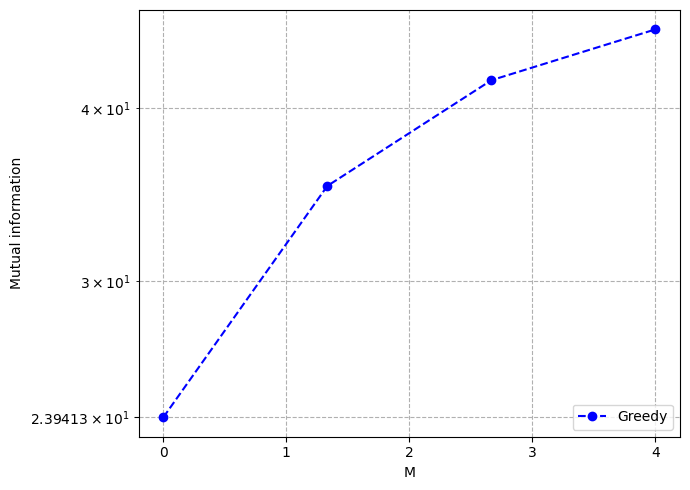

In [84]:
images_dir = '/content/gdrive/My Drive/Images'

IRS_num = linspace(0, M,M)
plt.semilogy(IRS_num, f_S, 'bo--',label='Greedy') # plotting t, a separately
plt.grid(True,which='both',linestyle='--')
plt.xlabel(r'M')
plt.ylabel(r'Mutual information')
plt.legend(loc="lower right", prop={'weight': 'normal'})
plt.xticks(np.arange(min(IRS_num), max(IRS_num)+1, 1))
plt.yticks(np.arange(min(f_S), max(f_S),0.01))
plt.savefig("/content/gdrive/My Drive/Images/Fig2_CAMSAP.eps", format="eps", bbox_inches="tight", transparent=True)
plt.show()

<ipython-input-85-56ecc12136fa>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c = ax.scatter(theta, r, c='g',marker="*",s=100 ,cmap='hsv', alpha=1)
<ipython-input-85-56ecc12136fa>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c = ax.scatter(theta_t, r_t, c='r',s=150, cmap='hsv',marker="^", alpha=1)
<ipython-input-85-56ecc12136fa>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c = ax.scatter(theta_r, r_r, c='b', cmap='hsv', alpha=1,marker="o")


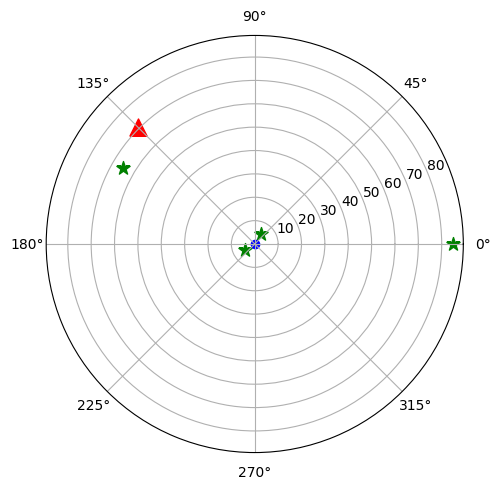

In [85]:
plt.rcParams["figure.figsize"] = [7,5]
plt.rcParams["figure.autolayout"] = True

N = 150
r = [x[0] for x in set_S]
theta = [x[1] for x in set_S]
#area = 200 * np.array(r)**2

colors = theta

# IRSs
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta, r, c='g',marker="*",s=100 ,cmap='hsv', alpha=1)

#Target
(r_t,theta_t)=cart2pol(params.target_position[0],params.target_position[1])
c = ax.scatter(theta_t, r_t, c='r',s=150, cmap='hsv',marker="^", alpha=1)
#Radar
(r_r,theta_r)=cart2pol(params.radar[0],params.radar[1])
c = ax.scatter(theta_r, r_r, c='b', cmap='hsv', alpha=1,marker="o")

plt.savefig("/content/gdrive/My Drive/Images/Fig3_CAMSAP.eps", format="eps", bbox_inches="tight", transparent=True)



##Exhaustive search##

In [86]:
def  exhaustive_search(params,m):


  f_S_temp_ex=[]
  updated_B= powerset_M(params.A,m)
  for e in updated_B:
    set_S_temp=list(copy.deepcopy(e))
    f_S_temp_ex.append(compute_objective(set_S_temp,params))

  sel_ex=np.argmax(np.real(f_S_temp_ex))
  set_S_ex=updated_B[sel_ex]
  print('Optimal Objective value for',m,'IRSs' ,real(f_S_temp_ex[sel_ex]))
  print('final set of locations',set_S_ex,'\n')
  return np.real(f_S_temp_ex[sel_ex])




In [87]:
f_S_ex=[]
for  m in range(params.M):
  f_S_ex.append((1-1/np.e)*exhaustive_search(params,m+1))  # The curvature  of the  objective is  previously  empirically calculated at it is very close to  1   i.e. c ~ 0.996

Optimal Objective value for 1 IRSs 23.94133500657621
final set of locations ((5, 1.0471975511965976),) 

Optimal Objective value for 2 IRSs 35.70395172799793
final set of locations ((25, 1.5707963267948966), (65, 2.617993877991494)) 

Optimal Objective value for 3 IRSs 42.05376569256735
final set of locations ((5, 3.665191429188092), (25, 1.5707963267948966), (65, 2.617993877991494)) 



KeyboardInterrupt: ignored

##Random placement##

In [88]:

f_S_rand=[]
for  m in range(params.M+1):

          set_S_rand=random.choice(powerset_M(params.A,m+1))
          f_S_rand.append(compute_objective(set_S_rand,params))
print(f_S_rand)

[(22.07481679747165+1.975858194854526e-14j), (21.226136932044056+2.4702608987007337e-13j), (26.88647027238407-1.4866137009351956e-13j), (33.216173578952585+1.1097925865220698e-13j), (33.96683531973525+2.8366475289012417e-12j)]


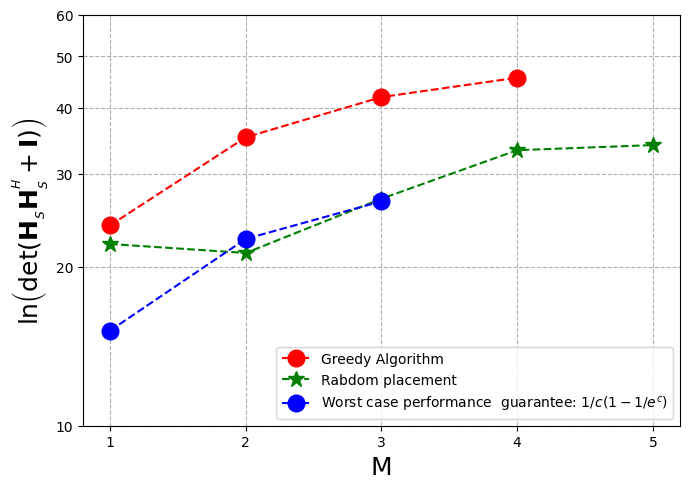

In [89]:
images_dir = '/content/gdrive/My Drive/Images'
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.serif'] = 'Times New Roman'

M=4
legend_properties = {'weight':'bold','size': 11}



IRS_num =np.linspace(1, M+1,M)





plt.semilogy(np.arange(1,M+1), np.real(f_S), 'ro--',label='Greedy Algorithm',markersize=12) # plotting t, a separately
plt.semilogy(np.arange(1,M+2), np.real(f_S_rand), 'g*--',label='Rabdom placement',markersize=12) # plotting t, a separately
plt.semilogy(np.arange(1,len(f_S_ex)+1), np.real(f_S_ex), 'bo--',label=r'Worst case performance  guarantee: $1/c(1-1/e^c)$',markersize=12) # plotting t, a separately

plt.xticks(np.arange(min(IRS_num), max(IRS_num)+1, 1))

plt.yticks(np.arange(10, 70,10),['10','20','30','40','50','60'])


plt.grid(True,which='both',linestyle='--')
plt.xlabel(r'M',fontsize=18)
plt.ylabel(r'$\mathrm{ln}\left(\mathrm{det}(\mathbf{H}_{_{S}} \mathbf{H}_{_{S}}^{^H}+ \mathbf{I})\right)$',fontsize=18)
plt.legend(loc='lower right')

plt.savefig("/content/gdrive/My Drive/Images/Fig2_CAMSAP.eps", format="eps", bbox_inches="tight", transparent=True)
plt.show()